In [ ]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime

In [ ]:
#Loading and cleaning the data
df=pd.read_csv("Nat_Gas.csv")

In [ ]:
df['Dates'] = pd.to_datetime(df['Dates'], format="%m/%d/%y")

In [ ]:
#Set Date as index
df.set_index('Dates',inplace=True)

In [ ]:
df=df.asfreq('ME')

In [ ]:
df=df.sort_index()

In [ ]:
print(df.head())

            Prices
Dates             
2020-10-31    10.1
2020-11-30    10.3
2020-12-31    11.0
2021-01-31    10.9
2021-02-28    10.9


In [ ]:
print(df.index.freq)

<MonthEnd>


In [ ]:
#Interpolation

In [ ]:
#Reindex to daily dates
daily_index = pd.date_range(start=df.index.min(), end=df.index.max(),freq='D')

In [ ]:
#Interpolate linearly for missing days
df_daily = df.reindex(daily_index)
df_daily['Prices'] = df_daily['Prices'].interpolate(method='linear')

In [ ]:
#Extrapolation (forecast 12 months)

In [ ]:
#Using Exponential Smoothing for seasonality and trend
model = ExponentialSmoothing(df['Prices'], trend="add", seasonal="add", seasonal_periods=12)
fit = model.fit()

In [ ]:
#Forecasting 12 months ahead
forecast = fit.forecast(12)

In [ ]:
#Creating future date index
future_index = pd.date_range(start=df.index.max() + pd.offsets.MonthEnd(1) , periods=12, freq='ME')
forecast_df = pd.DataFrame({'Prices': forecast.values}, index=future_index)

In [ ]:
#Combining actual and forecast
full_series = pd.concat([df,forecast_df])

In [ ]:
#Function to query price

In [ ]:
def get_price_estimate(input_date:str) -> float:
  """
  Takes a date string(YYYY-MM-DD) and returns an estimatednatural gas price.
  Handles both historical (interpolated) and extrapolated dates.
  """

  query_date = pd.to_datetime(input_date)

  if query_date <= df_daily.index.max():
    #Historical or within orignal range -> use daily interpolated values
    return float(df_daily.loc[query_date, 'Prices'])
  elif query_date <= full_series.index.max():
    #Future date within forecast horizon
    #Align to month-end since forecast is monthly
    nearest_month = query_date + pd.offsets.MonthEnd(0)
    return float(full_series.loc[nearest_month, 'Prices'])
  else:
    raise ValueError("Date beyond forecast horizon (only up to 12 months ahead supported).")

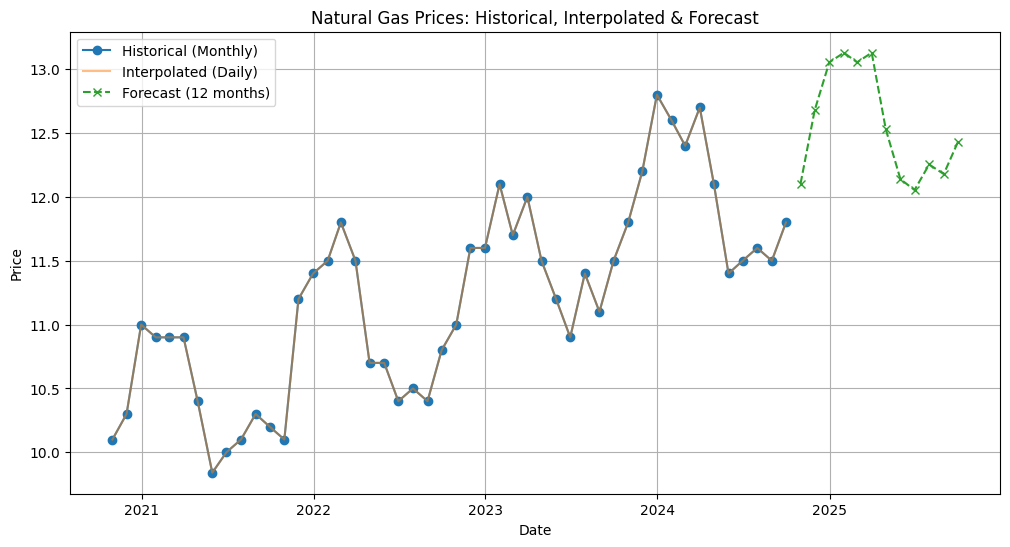

In [ ]:
#Visualization
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Prices'], label="Historical (Monthly)", marker="o")
plt.plot(df_daily.index, df_daily['Prices'], label="Interpolated (Daily)", alpha=0.5)
plt.plot(forecast_df.index, forecast_df['Prices'], label="Forecast (12 months)", linestyle="--", marker="x")
plt.title("Natural Gas Prices: Historical, Interpolated & Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print("Price on 2021-03-15:", get_price_estimate("2021-03-15"))
print("Price on 2024-07-10:", get_price_estimate("2024-07-10"))
print("Price on 2025-03-31:", get_price_estimate("2025-03-31"))

Price on 2021-03-15: 10.9
Price on 2024-07-10: 11.532258064516128
Price on 2025-03-31: 13.128751394213287
